In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave
from random import sample
import pandas as pd
from scipy import fftpack
from scipy.signal import butter, filtfilt
from statsmodels.graphics.tsaplots import plot_acf
import plotly.graph_objects as go 

# Plotting

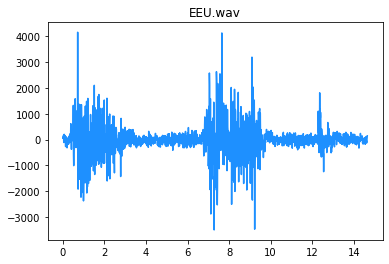

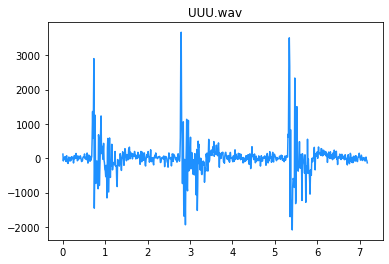

In [2]:
def plot_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    Time = np.linspace(0, len(signal) / fs, num=len(signal))

    plt.figure(1)
    title = str(path.split("arm_signal/")[-1])
    
    plt.title(title)
    plt.plot(Time[::100], signal[::100], color = 'dodgerblue')
    plt.show()

plot_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/EEU.wav")
plot_wave("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/UUU.wav")




# Classifier

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


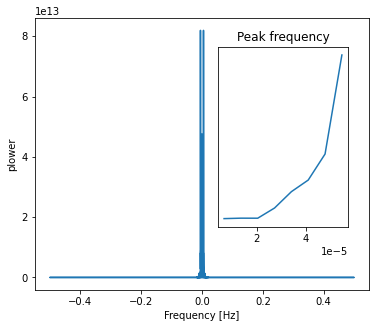

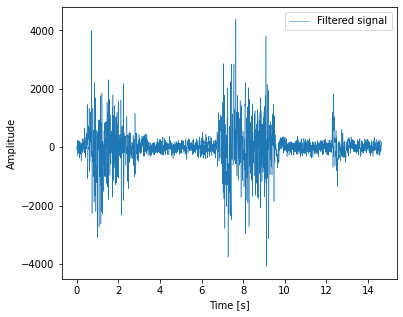

In [3]:
def filter_plot(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    Time = np.linspace(0, len(signal) / fs, num=len(signal))
    sig = signal 
    sig_fft = fftpack.fft(sig)
    power = np.abs(sig_fft)**2
    period = 5

    # The corresponding frequencies
    sample_freq = fftpack.fftfreq(sig.size)

    # Plot the FFT power
    plt.figure(figsize=(6, 5))
    plt.plot(sample_freq, power)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('plower')

    # Find the peak frequency: we can focus on only the positive frequencies
    pos_mask = np.where(sample_freq > 0)
    freqs = sample_freq[pos_mask]
    peak_freq = freqs[power[pos_mask].argmax()]

    # Check that it does indeed correspond to the frequency that we generate
    # the signal with
    np.allclose(peak_freq, 1./period)

    # An inner plot to show the peak frequency
    axes = plt.axes([0.55, 0.3, 0.3, 0.5])
    plt.title('Peak frequency')
    plt.plot(freqs[:8], power[:8])
    plt.setp(axes, yticks=[])   

    high_freq_fft = sig_fft.copy()
    high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
    filtered_sig = fftpack.ifft(high_freq_fft)

    plt.figure(figsize=(6, 5))
    plt.plot(Time, filtered_sig, linewidth=0.5, label='Filtered signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.legend(loc='best')
filter_plot("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/EEU.wav")


In [4]:
def prep_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    time = np.linspace(0, len(signal) / fs, num=len(signal))
    return signal, fs, time 

signal,fs,time = prep_wave("arm_signal/EEU.wav")
nyq = 0.3*fs
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
    
def fft(path, cutoff = 5, plot = False):
    t = 5
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    Time = np.linspace(0, len(signal) / fs, num=len(signal))
    sig = signal 
    cutoff = cutoff
    order = 2
    y = butter_lowpass_filter(signal, cutoff, fs, order)

    if plot == True:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
                    y = signal,
                    line =  dict(shape =  'spline' ),
                    name = 'signal with noise'
                    ))
        fig.add_trace(go.Scatter(
                    y = y,
                    line =  dict(shape =  'spline' ),
                    name = 'filtered signal'
                    ))

        fig.show()
    return y, Time 
filter_signal, time = fft("arm_signal/EEU.wav", plot = True)

    
    

In [5]:

def movement_classifier(data, time, down_sample_rate = 50, window_size = 0.3, threshold_events = 100, difference = 0.4):
    # 1. Down Sampling
    ind = np.arange(0, np.where(np.round(time,4) == round(time[len(time) - 1] - window_size, 4))[0][0], down_sample_rate)
    t_stat = [0]*len(ind)

    # 2. Calculating SD
    for i in range(len(ind)):
        data_subset = data[ind[i] : ind[i] + int(window_size * down_sample_rate)]
        t_stat[i] = np.std(data_subset)

    # 3. Use threshold to determine movement intervals
    predicted_event = [x for x in range(len(t_stat)) if t_stat[x] > threshold_events]

    # time vector for middle of each window 
    time_middle = []
    for i in predicted_event:
        time_middle.append(time[ind[i]] + window_size/2)

    # 4. Estimation 
    intervals = [] 
    cut_point = predicted_event[0]
    last_interval = 0

    middle_time = int(down_sample_rate * window_size/2)
    for i in range(len(predicted_event) - 1):
        if predicted_event[i+1] != predicted_event[i] + 1:
            # combine intervals together if the predicted intervals are with difference amount
            if last_interval == 0:
                intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            else:
                if ((int(ind[cut_point] + middle_time)/10000) - last_interval[1]) < difference:
                    last_interval[1] = int(ind[predicted_event[i]] + middle_time)/10000
                else:
                    intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            
            cut_point = predicted_event[i+1]
                    
    return intervals

# Preparing Wave File

In [6]:
def prep_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    time = np.linspace(0, len(signal) / fs, num=len(signal))
    return signal, time 

In [7]:
def predict(intervals):
    for i in range(len(intervals)):
        if intervals[i][1] - intervals[i][0] < 1:
            print("Turn")
        elif intervals[i][1] - intervals[i][0] >= 1:
            print("Tension")

In [8]:
signal_EEU, time = fft("arm_signal/EEU.wav", plot = False)
predict(movement_classifier(signal_EEU, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3)
)

Tension
Tension
Turn


In [9]:
signal_EUE, time = fft("arm_signal/EUE.wav")
predict(movement_classifier(signal_EUE, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3)
)

Tension
Turn
Tension


In [10]:
signal_EUU, time = fft("arm_signal/EUU.wav")
predict(movement_classifier(signal_EUU, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3)
)

Tension
Turn
Turn


In [11]:
signal_UEE, time = fft("arm_signal/UEE.wav")
predict(movement_classifier(signal_UEE, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3))

Turn
Tension
Tension


In [12]:
signal_UEU, time = fft("arm_signal/UEU.wav")
predict(movement_classifier(signal_UEU, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3))

Turn
Tension
Turn


In [13]:
signal_UUE, time = fft("arm_signal/UUE.wav")
predict(movement_classifier(signal_UUE, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3))

Turn
Turn
Tension


In [14]:
signal_UUU, time = fft("arm_signal/UUU.wav")
predict(movement_classifier(signal_UUU, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3))

Turn
Turn
Turn


In [15]:
def extract_signal(intervals, data):
    if intervals[0][0] >= intervals[0][1]:
        print("Error")
        return [0] 
    ret_data = []
    for i in range(len(data)):
        if i >= intervals[0][0] and i < intervals[0][1]:
            ret_data.append(data[i])
    return ret_data

In [16]:
extract_signal(movement_classifier(signal_EUU, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3)
, data = time)



[0.00010000139246675486, 0.00020000278493350972]

# Finish Classifier


In [18]:
def predict_wave(path,down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3, plot = False, cutoff = 5):
    t = 5
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    time = np.linspace(0, len(signal) / fs, num=len(signal))
    sig = signal 
    cutoff = cutoff
    order = 2
    data  = butter_lowpass_filter(signal, cutoff, fs, order)

    if plot == True:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
                    y = signal,
                    line =  dict(shape =  'spline' ),
                    name = 'signal with noise'
                    ))
        fig.add_trace(go.Scatter(
                    y = data,
                    line =  dict(shape =  'spline' ),
                    name = 'filtered signal'
                    ))

        fig.show()
    # 1. Down Sampling
    ind = np.arange(0, np.where(np.round(time,4) == round(time[len(time) - 1] - window_size, 4))[0][0], down_sample_rate)
    t_stat = [0]*len(ind)
    # 2. Calculating SD
    for i in range(len(ind)):
        data_subset = data[ind[i] : ind[i] + int(window_size * down_sample_rate)]
        t_stat[i] = np.std(data_subset)
    # 3. Use threshold to determine movement intervals
    predicted_event = [x for x in range(len(t_stat)) if t_stat[x] > threshold_events]
    # time vector for middle of each window 
    time_middle = []
    for i in predicted_event:
        time_middle.append(time[ind[i]] + window_size/2)
    # 4. Estimation 
    intervals = [] 
    cut_point = predicted_event[0]
    last_interval = 0
    middle_time = int(down_sample_rate * window_size/2)
    for i in range(len(predicted_event) - 1):
        if predicted_event[i+1] != predicted_event[i] + 1:
            # combine intervals together if the predicted intervals are with difference amount
            if last_interval == 0:
                intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            else:
                if ((int(ind[cut_point] + middle_time)/10000) - last_interval[1]) < difference:
                    last_interval[1] = int(ind[predicted_event[i]] + middle_time)/10000
                else:
                    intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            
            cut_point = predicted_event[i+1]             
    for i in range(len(intervals)):
        if intervals[i][1] - intervals[i][0] < 1:
            print("Turn")
        elif intervals[i][1] - intervals[i][0] >= 1:
            print("Tension")
    
  


In [19]:
predict_wave("arm_signal/UUU.wav")

Turn
Turn
Turn
